In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import YGate, UnitaryGate
import numpy as np


SYGate = UnitaryGate(YGate().power(1/2), label=r"$\sqrt{Y}$")
SYdgGate = UnitaryGate(YGate().inverse(), label=r"$\sqrt{Y}^\dag$")

def G1dtft(num_qubits, num_trotter_steps, rx_angle, num_cl_bits = 0, trotter_barriers=False, layer_barriers = False):
    qc = QuantumCircuit(num_qubits, num_cl_bits)
    if num_cl_bits == 0: 
        qc = QuantumCircuit(num_qubits)
    else:
        qc = QuantumCircuit(num_qubits, num_cl_bits)

    for trotter_step in range(num_trotter_steps):
        add_1dtft(qc, rx_angle, layer_barriers)

        if trotter_barriers:
            qc.barrier()
            
    return qc

def add_1dtft(qc,rx_angle, layer_barriers = False):
    for i in range(0,qc.num_qubits-1,2):
        qc.sdg([i, i+1])
        qc.append(SYGate,[i+1])
        qc.cx(i,[i+1])
        qc.append(SYdgGate,[i+1])
    
    if layer_barriers:
        qc.barrier()

    for i in range(1,qc.num_qubits-1,2):
        qc.sdg([i, i+1])
        qc.append(SYGate,[i+1])
        qc.cx(i,[i+1])
        qc.append(SYdgGate,[i+1])

    if layer_barriers:
        qc.barrier()

    qc.rx(rx_angle,list(range(qc.num_qubits)))

    if layer_barriers:
        qc.barrier()




In [ ]:
num_qubits = 6

num_trotter_steps = 1

rx_angle = 0.5* np.pi

qc = G1dtft(num_qubits,num_trotter_steps,rx_angle,trotter_barriers=True, layer_barriers = True)
qc.draw(output="mpl",fold=-1)

# demo: sampler

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import YGate, UnitaryGate
import numpy as np


SYGate = UnitaryGate(YGate().power(1/2), label=r"$\sqrt{Y}$")
SYdgGate = UnitaryGate(YGate().inverse(), label=r"$\sqrt{Y}^\dag$")

def mirror_G1dtft(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers=False, layer_barriers = False):

    for trotter_step in range(num_trotter_steps):
        add_mirror_1dtft(qc, rx_angle, layer_barriers)

        if trotter_barriers:
            qc.barrier()

def add_mirror_1dtft(qc,rx_angle, layer_barriers = False):

    qc.rx(-rx_angle,list(range(qc.num_qubits)))

    if layer_barriers:
        qc.barrier()

    for i in range(1,qc.num_qubits-1,2):
        qc.append(SYGate,[i+1])
        qc.cx(i,[i+1])
        qc.append(SYdgGate,[i+1])
        qc.s([i, i+1])

    if layer_barriers:
        qc.barrier()

    for i in range(0,qc.num_qubits-1,2):
        qc.append(SYGate,[i+1])
        qc.cx(i,[i+1])
        qc.append(SYdgGate,[i+1])
        qc.s([i, i+1])   
    
        

    if layer_barriers:
        qc.barrier()



In [ ]:
mirror_G1dtft(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers = True)
qc.draw(output='mpl',fold=1)

# Map the circuits and observables

In [ ]:
max_trotter_steps = 100
num_qubits = 100

measured_qubits = [49, 50]

qc_list = []
for trotter_step in range(max_trotter_steps):
    qc = G1dtft(num_qubits, num_trotter_steps, rx_angle, num_cl_bits=len(measured_qubits),trotter_barriers=True, layer_barriers = True)
    mirror_G1dtft(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers = True)
    qc.measure(measured_qubits, list(range(len(measured_qubits))))
    qc_list.append(qc)

# step 2: optimization

In [ ]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService

backend_name = "ibm_torino"
service = QiskitRuntimeService()

backend = service.backend(backend_name)

qc_transpiled_list = transpile(qc_list, backend=backend, optimization_level=1)

# Step 3: Execute on hardware

In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.options.sampler_options import SamplerOptions

sampler = Sampler(mode=backend)
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"

job = sampler.run(qc_transpiled_list)
job_id = job.job_id()
print(job_id)

# Post Processing

In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService
survival_probability_list = []
max_trotter_steps = 100

service = QiskitRuntimeService()
job = service.job("ct57kc5kmkz00086mjz0")
for trotter_step in range(max_trotter_steps):
    try:
        data = job.result()[trotter_step].data
        survival_probability_list.append(data.c.get_counts()["0" * len(measured_qubits)]/data.c.num_shots)
    except:
        survival_probability_list.append(0)

<function matplotlib.pyplot.show(close=None, block=None)>

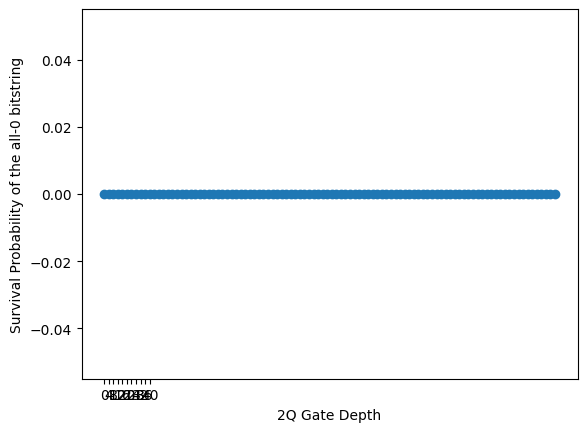

In [5]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(list(range(0, 4 * max_trotter_steps, 4)), survival_probability_list, "--o")

plt.xlabel("2Q Gate Depth")
plt.ylabel("Survival Probability of the all-0 bitstring")
plt.xticks(np.arange(0, 44, 4))
plt.show